Sascha Spors, Professorship Signal Theory and Digital Signal Processing, Institute of Communications Engineering (INT), Faculty of Computer Science and Electrical Engineering (IEF), University of Rostock, Germany

# Selected Topics in Audio Signal Processing - Exercises



The notebooks and all additional files should be considered as [Open Educational Resources](https://en.wikipedia.org/wiki/Open_educational_resources). The text is licensed under Creative Commons Attribution 4.0, the code of the IPython examples under the MIT license.

# Farfield Directivity of an Steered Uniform Linear Array

Uniform Linear Array (ULA)

Theory...WIP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.core.umath_tests import inner1d
from numpy.fft import ifft  # for the spatial domain this is the transform from y to ky
from scipy.special import diric  # periodic sinc

/Users/fs446/opt/anaconda3/envs/mystiasp/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  This is separate from the ipykernel package so we can avoid doing imports until


In [2]:
def plot_ula_farfield_directivity(x, phi_steer, w, c=343, check_flag=False):
    """Calculate and plot the farfield directivity of steered ULA.
    x: (N, 2), 2D array of ULA element positions on +y axis starting at y=0
    phi_steer: steering angle in deg
    w: angular frequency in rad/s
    c = 343  # m/s, speed of sound

    this function derives the directivity H numerically/analytically from
    1.) iDFT of array's weights
    2.) iDFT to iDTFT interpolation for spatial frequency ky
    3.) getting as many circle rounds as required to fill visible region +-w/c
    4.) cut out the visible region data
    5.) check numeric approach against analytical solution
    6.) plot |H| over ky
    7.) plot 20lg|H| over phi as polar and normal 2D
    8.) plot ULA geometry
    """
    kys = 2*np.pi/dy  # spatial sampling frequency in rad/m
    w_c = w/c  # wave number in rad/m

    # 2D steering vector in kx-ky-domain
    k_steer = w/c * np.array([np.cos(phi_steer/180*np.pi),
                              np.sin(phi_steer/180*np.pi)])
    k_steer = k_steer[:, np.newaxis].T
    ky_steer = k_steer[0, 1]  # ky entry

    print('for a transmitting ULA')
    if phi_steer < 0:
        tau = -ky_steer*dy/w*1000
        print(
            'start delay increments by tau = {0:f} ms from top element'.format(tau))
    else:
        tau = +ky_steer*dy/w*1000
        print(
            'start delay increments by tau = {0:f} ms from bottom element'.format(tau))

    # array weights for delay-and-sum for the chosen frequency w
    # TBD: windowing
    h = np.exp(-1j*inner1d(x, k_steer))

    # calc a spatial iDTFT-like spectrum which is the base for the directivity
    # note that we need the ifft() here for the used sign convention between
    # temporal and spatial fourier transforms
    Nz = 2**10  # large zeropadding -> high res iDFT = interpolation to iDTFT
    H_base = np.zeros(Nz, dtype='complex')  # alloc ram, complex!!
    H_base[0:N] = h  # insert weights
    H_base = ifft(H_base)*Nz/N  # ifft and normalize directivity max to 1
    ky_base = np.arange(Nz)/Nz*kys  # baseband of spatial wavenumber ky vector
    # i.e. 0...kys=2 pi / dy

    # variables to store the complete directivity:
    ky = np.zeros(Nz)
    H = np.zeros(Nz)

    # get the directivity by running along the z-plane unit circle
    # as long as required for the chosen sampling dy and frequency w:
    # NOTE: the directivity is highly dependent on dy and w
    # however, for a chosen dy, H_base contains all spatial information
    # the specific w determines what information of H_base is actually used
    # to render the frequency dependent directivity
    # that's what we do with the for loop:
    Nmu = np.int(np.ceil(w_c / kys))
    if Nmu > 1:
        print('we have grating lobes within the visible region')
        print('thus spatial aliasing occurs')
    start_flag = True
    for mu in range(-Nmu, +Nmu+1):
        if start_flag == True:
            ky = ky_base + kys*mu
            H = H_base
            start_flag = False
        else:
            ky = np.append(ky, ky_base + kys * mu)
            H = np.append(H, H_base)

    # cut out the visible region, i.e. -w/c <= ky <= w/c
    # which maps to phi = -90...+90deg
    ky_wc = ky[np.abs(ky) <= w_c]
    phi_wc = np.arcsin(ky_wc/(w_c))
    Hcpx_wc = H[np.abs(ky) <= w_c]
    Habs_wc = np.abs(Hcpx_wc)
    HdB_wc = 20*np.log10(Habs_wc)

    # analytic solution
    # cf. e.g. Ch. 3.2.5 in https://doi.org/10.18453/rosdok_id00001765
    # cf. e.g. Ch. 3.2ff in https://onlinelibrary.wiley.com/doi/book/10.1002/0471221104
    tmp = (ky_wc - ky_steer) * dy
    Hcpx_analyic_wc = np.exp(1j*tmp*(N-1)/2)  # phase
    Hcpx_analyic_wc *= diric(tmp, N)  # psinc & normalization
    Habs_analyic_wc = np.abs(Hcpx_analyic_wc)
    HdB_analyic_wc = 20*np.log10(np.abs(Habs_analyic_wc))

    if check_flag:  # check Hnumeric == Hanalytic
        plt.figure(figsize=(10, 3))
        plt.plot(ky_wc, np.real(Hcpx_wc-Hcpx_analyic_wc), 'C0', label='re')
        plt.plot(ky_wc, np.imag(Hcpx_wc-Hcpx_analyic_wc), 'C1', label='im')
        plt.xlabel('ky')
        plt.title('Hnumeric - Hanalytic')
        plt.legend()
        plt.grid(True)

    # do the plot job
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 3)
    plt.plot(ky_wc, Habs_wc)
    plt.xlabel(
        r'$-\frac{\omega}{c} \,\leq\, k_y = \frac{\omega}{c} \cdot \sin(\varphi) \,\leq\, +\frac{\omega}{c}$')
    plt.ylabel('|H|')
    plt.xlim(-w_c, +w_c)
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(phi_wc * 180/np.pi, HdB_wc)
    plt.xlabel(r'$\varphi$')
    plt.ylabel('20lg|H| / dB')
    plt.xlim(-90, 90)
    plt.ylim(-36, 0)
    plt.yticks(np.arange(-36, 6, 6))
    plt.xticks(np.arange(-90, 90+15, 15))
    plt.grid(True)

    ax = plt.subplot(2, 2, 2, projection='polar')
    ax.plot(phi_wc, HdB_wc)
    ax.set_rticks(np.arange(-36, 6, 6))
    ax.set_ylim(-36, 0)
    ax.set_xticks(np.arange(-90, 90+15, 15)/180*np.pi)
    ax.set_thetalim(-1/2*np.pi, 1/2*np.pi)

    plt.subplot(2, 2, 1)
    plt.plot(x[:, 0], x[:, 1], 'C0o')
    plt.xlabel('x / m')
    plt.ylabel('y / m')
    plt.title(r'ULA length $N\cdot \Delta y={0:f}$ m'.format(N*dy))
    plt.grid(True)

## Broadside Array, No Aliasing

for a transmitting ULA
start delay increments by tau = 0.000000 ms from bottom element
-0.7071067811865475
0.7071067811865475


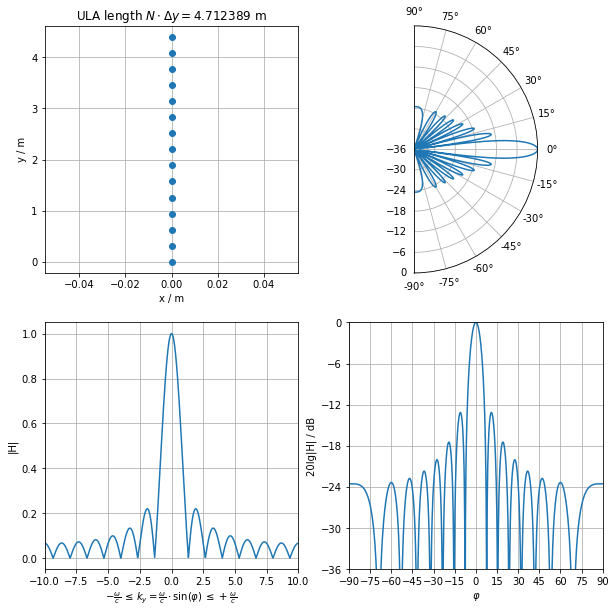

In [3]:
N = 15  # number of elements in ULA
phi_steer = 0  # deg
w = 10*343  # rad/s
dy = 2*np.pi/20  # m

x = np.array([np.zeros(N), np.arange(N)*dy]).T  # along +y axis
plot_ula_farfield_directivity(x, phi_steer, w)

print(np.sin(-45*np.pi/180))
print(np.sin(+45*np.pi/180))

## Downsteered Array -60deg, No Aliasing

for a transmitting ULA
start delay increments by tau = 0.793207 ms from top element


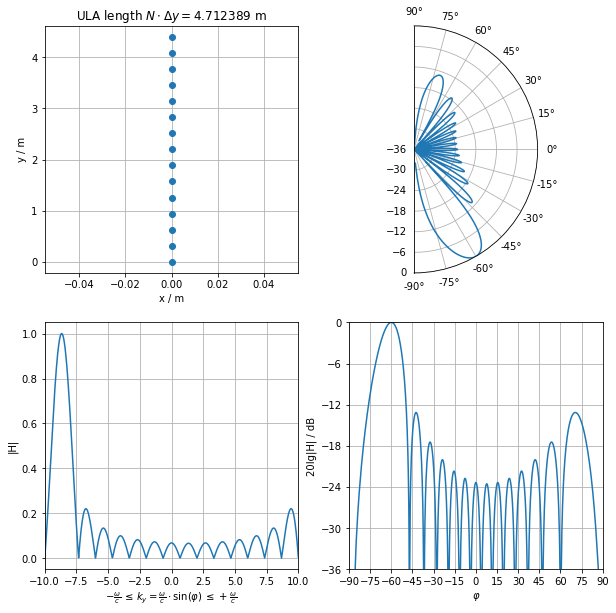

In [4]:
N = 15  # number of elements in ULA
phi_steer = -60  # deg
w = 10*343  # rad/s
dy = 2*np.pi/20  # m

x = np.array([np.zeros(N), np.arange(N)*dy]).T  # along +y axis
plot_ula_farfield_directivity(x, phi_steer, w)

## Upsteered Array +45deg, No Aliasing

for a transmitting ULA
start delay increments by tau = 0.647651 ms from bottom element


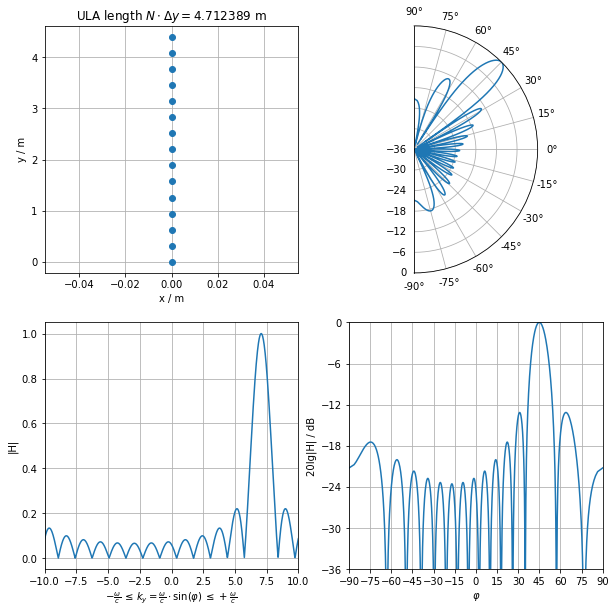

In [5]:
N = 15  # number of elements in ULA
phi_steer = +45  # deg
w = 10*343  # rad/s
dy = 2*np.pi/20  # m

x = np.array([np.zeros(N), np.arange(N)*dy]).T  # along +y axis
plot_ula_farfield_directivity(x, phi_steer, w)

## Endfire Array, No Aliasing

for a transmitting ULA
start delay increments by tau = 0.915916 ms from top element


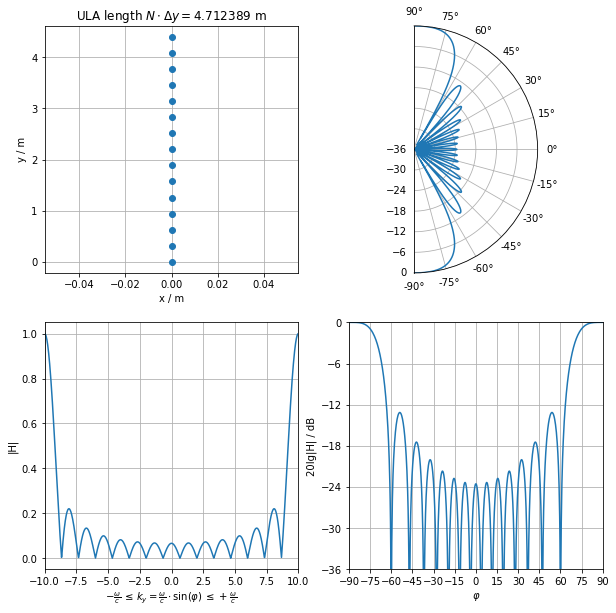

In [6]:
N = 15  # number of elements in ULA
phi_steer = -90  # deg
w = 10*343  # rad/s
dy = 2*np.pi/20  # m

x = np.array([np.zeros(N), np.arange(N)*dy]).T  # along +y axis
plot_ula_farfield_directivity(x, phi_steer, w)

## Broadside Array, Spatial Aliasing, Grating Lobes at +-90 deg

for a transmitting ULA
start delay increments by tau = 0.000000 ms from bottom element


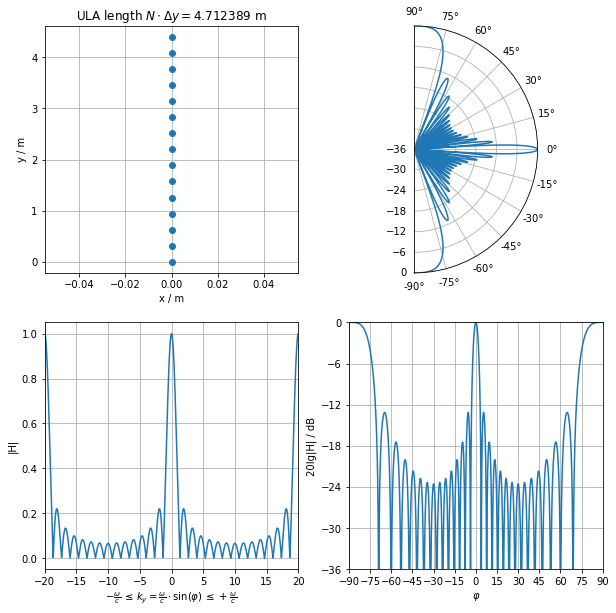

In [7]:
N = 15  # number of elements in ULA
phi_steer = 0  # deg
w = 10*343*2  # rad/s
dy = 2*np.pi/20  # m

x = np.array([np.zeros(N), np.arange(N)*dy]).T  # along +y axis
plot_ula_farfield_directivity(x, phi_steer, w)

## Broadside Array, Spatial Aliasing, Grating Lobes at +-90 deg and +-30 deg

for a transmitting ULA
start delay increments by tau = 0.000000 ms from bottom element
we have grating lobes within the visible region
thus spatial aliasing occurs


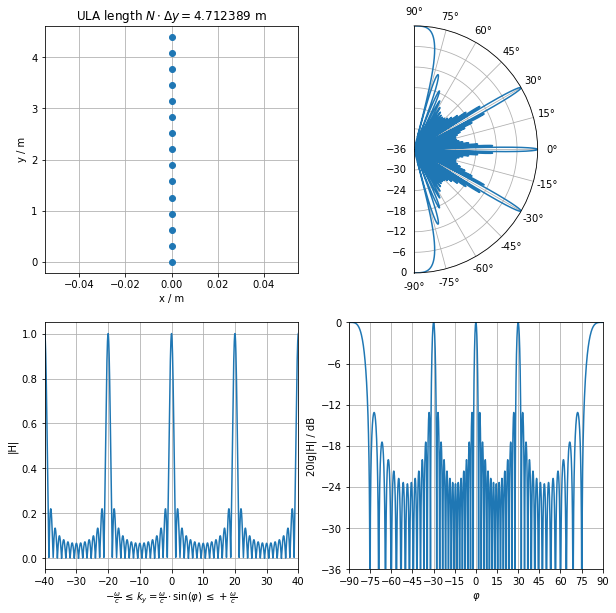

In [8]:
N = 15  # number of elements in ULA
phi_steer = 0  # deg
w = 10*343*4  # rad/s
dy = 2*np.pi/20  # m

x = np.array([np.zeros(N), np.arange(N)*dy]).T  # along +y axis
plot_ula_farfield_directivity(x, phi_steer, w)

## Downsteered Array to -45 deg, 3 Grating Lobes

for a transmitting ULA
start delay increments by tau = 0.647651 ms from top element
we have grating lobes within the visible region
thus spatial aliasing occurs


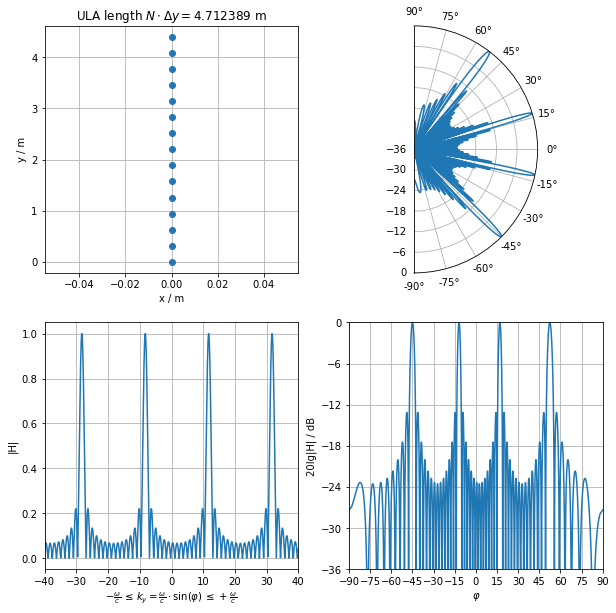

In [9]:
N = 15  # number of elements in ULA
phi_steer = -45  # deg
w = 10*343*4  # rad/s
dy = 2*np.pi/20  # m

x = np.array([np.zeros(N), np.arange(N)*dy]).T  # along +y axis
plot_ula_farfield_directivity(x, phi_steer, w)

## Downsteered ULA with Same Length but Different Number of Elements and Thus Different Element Spacing, -15 deg

In [10]:
phi_steer = -15  # deg
w = 2*np.pi*2000  # rad/s

### Array 1

- steering works, no grating lobes

for a transmitting ULA
start delay increments by tau = 0.057499 ms from top element


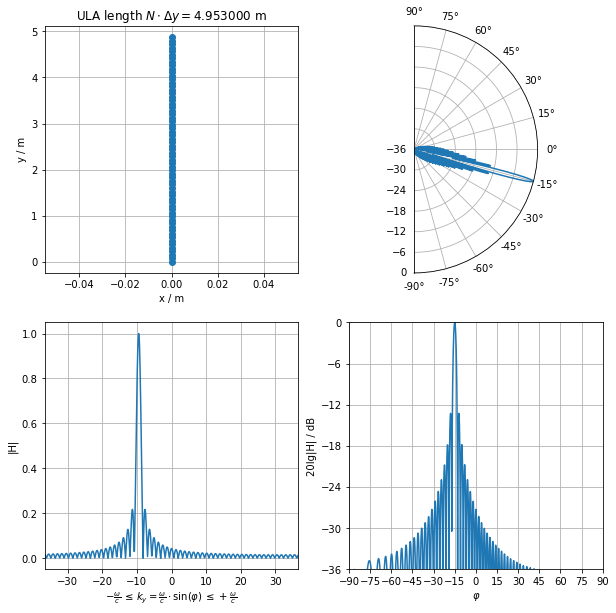

In [11]:
N = 65  # number of elements in ULA
dy = 3*2.54/100  # m

x = np.array([np.zeros(N), np.arange(N)*dy]).T  # along +y axis
plot_ula_farfield_directivity(x, phi_steer, w)

### Array 2 

- steering leads to additional 3 grating lobes, thus **receiving of transmitting direction is not unique**
- check that broadside array has 4 grating lobes

for a transmitting ULA
start delay increments by tau = 0.287493 ms from top element
we have grating lobes within the visible region
thus spatial aliasing occurs


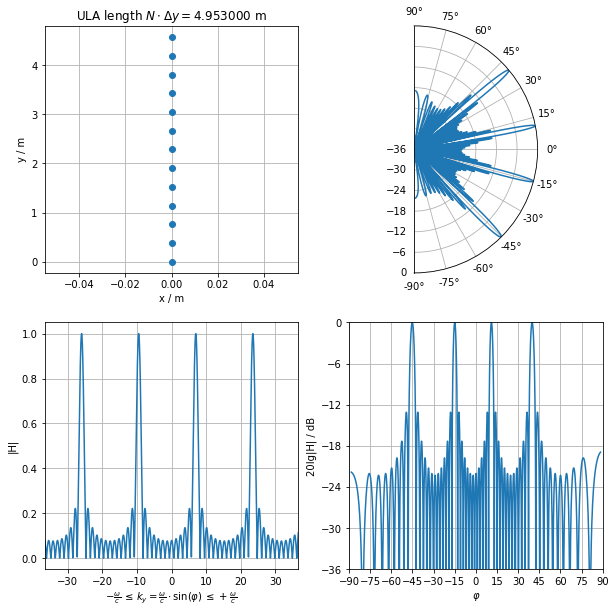

In [12]:
N = 13  # number of elements in ULA
dy = 15*2.54/100  # m

x = np.array([np.zeros(N), np.arange(N)*dy]).T  # along +y axis
plot_ula_farfield_directivity(x, phi_steer, w)